# **Configuración inicial**

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from arch import arch_model

import statsmodels.stats.diagnostic as smd
import pandas as pd
import numpy as np
import scipy as sc
import statsmodels.api as stats
import seaborn as sns
import arch 
import matplotlib.pyplot as plt
import os 

if os.getcwd().split('\\')[len(os.getcwd().split('\\'))-1] != "202510-Series-Taller2":
    os.chdir("..")
print(os.getcwd())

c:\Users\NicolasLozano\OneDrive - Universidad de los andes\UNIVERSIDAD\9. NOVENO SEMESTRE\SERIES DE TIEMPO\TALLERES\202510-Series-Taller2


## **2.a. Cargue de datos, transformación y grafico de la serie**

In [3]:
data_trm = pd.read_excel("data\\TRM.xlsx")

data_trm = data_trm.rename(columns={'Fecha (dd/mm/aaaa)':'date','Tasa de cambio representativa del mercado (TRM)':'trm'})

# Cobnnvertimos la columna fecha a datetime.
data_trm['date'] = pd.to_datetime(data_trm['date'], format='%Y/%m/%d')\

# Especificamos que la columna date debe tomarse como index.
data_trm.set_index('date', inplace=True)

# Se especifica que la frecuencia es diaria.
data_trm = data_trm.asfreq('D')

data_trm = data_trm.resample("M").mean()

print(data_trm)

                    trm
date                   
1991-12-31   630.412581
1992-01-31   644.058065
1992-02-29   635.671724
1992-03-31   640.501935
1992-04-30   649.955000
...                 ...
2024-11-30  4408.652333
2024-12-31  4385.148710
2025-01-31  4307.567419
2025-02-28  4127.953929
2025-03-31  4131.974400

[400 rows x 1 columns]


C:\Users\NicolasLozano\AppData\Local\Temp\ipykernel_34720\2011505052.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_trm = data_trm.resample("M").mean()


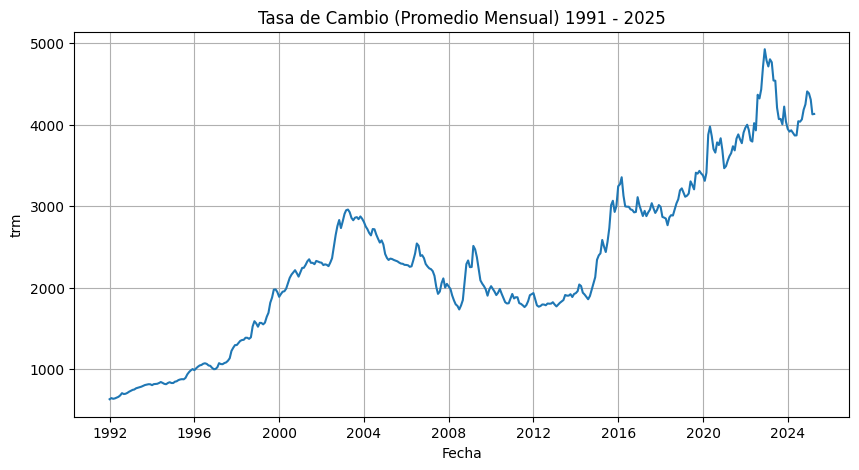

In [4]:
os.makedirs(".\\output", exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(data_trm.index,data_trm['trm'],linestyle='-')
plt.xlabel('Fecha')
plt.ylabel('trm')
plt.title('Tasa de Cambio (Promedio Mensual) 1991 - 2025')
plt.grid(True)
plt.savefig("output\\graf_trm.png", dpi=300, bbox_inches='tight')
plt.show()

## **2.b. Retorno de la trm**

In [5]:
data_trm['retorno']=(np.log(data_trm['trm'])-np.log(data_trm['trm'].shift(1)))*100

ret_promedio = pd.DataFrame({"Estad\\'istico": ["Retorno Mensual Promedio"], "Valor": [data_trm['retorno'].mean()]})

latex_table = ret_promedio.to_latex(index=False, label="tab:retorno_promedio", na_rep='0',multicolumn=True,position='H')
latex_table = latex_table.replace("\\begin{tabular}", "\\centering\n\\begin{tabular}")
latex_table = latex_table.replace("\\end{tabular}", f"\\end{{tabular}}\n\\caption{{Retorno Promedio}}")

with open("output\\retorno_promedio.tex", "w") as f:
     f.write(latex_table)



## **2.c. Retornos sin media al cuadrado**

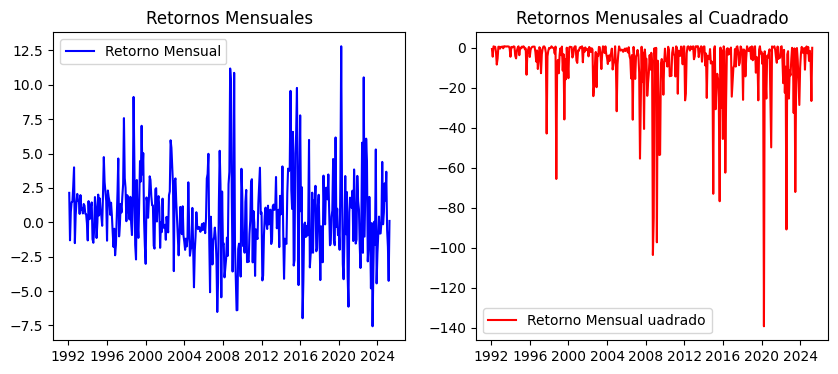

In [6]:
data_trm['retorno2']=data_trm['retorno']-np.square(data_trm['retorno']-data_trm['retorno'].mean())
data_trm['retorno_sin_media']=data_trm['retorno']-data_trm['retorno'].mean()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(data_trm.index,data_trm['retorno'],linestyle='-', label="Retorno Mensual", color="b")
ax[0].set_title("Retornos Mensuales")
ax[0].legend()

ax[1].plot(data_trm.index,data_trm['retorno2'],linestyle='-', label="Retorno Mensual uadrado", color="r")
ax[1].set_title("Retornos Menusales al Cuadrado")
ax[1].legend()
plt.savefig("output\\subplot_retornos.png", dpi=300, bbox_inches='tight')
plt.show()


## **2.d. ARIMA**

Revisamos si la serie es estacionaria

In [7]:
test_result = adfuller(data_trm["retorno"].dropna())

test_result = {
    '':["Estad\\'istico DF", 'p-valor'],
    'Valor':[round(test_result[0],4),round(test_result[1], 4)]
}

test_result = pd.DataFrame(test_result)

latex_table = test_result.to_latex(index=False, label="tab:dickey_fuller", na_rep='0',multicolumn=True,position='H',float_format="%.4f")
latex_table = latex_table.replace("\\begin{tabular}", "\\centering\n\\begin{tabular}")
latex_table = latex_table.replace("\\end{tabular}", f"\\end{{tabular}}\n\\caption{{Prueba Dickey-Fuller}}")

with open("output\\dikey_fuller.tex", "w") as f:
     f.write(latex_table)

Como el p-valor es prácticamente 0, rechazamos la hipotesis nula y conluimos que no hay evidencia estadistica de que la serie tenga raíz unitaria. <br>
Puede consultar la documentación de la función adfuller [aqui](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html). <br>
Ahora miramos las autocorrelaciones para estimar los parámetros p y q.

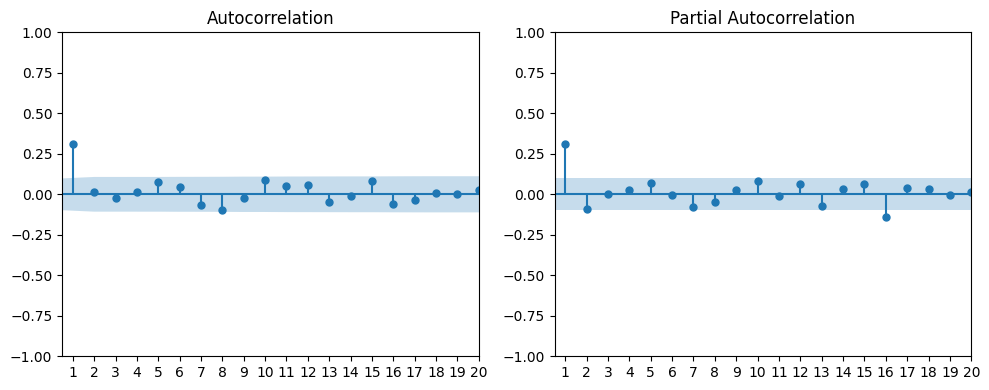

In [8]:
data_trm2 = data_trm.dropna()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_acf(data_trm2['retorno'], ax = axes[0], alpha=0.05, lags=20)
plot_pacf(data_trm2['retorno'], ax = axes[1], alpha=0.05, lags=20)
for ax in axes:
    xticks = ax.get_xticks()  
    ax.set_xticks(np.arange(1, 20 + 1)) 
    ax.set_xlim(0.5, 20)

plt.savefig("output\\acf_pacf_retornos.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

Vemos que las autocorrelaciones y las autocorrelaciones parciales rapidamente entran en los intervalos de confianza lo que refuerza la hipótesis de que la serie es estacionaria.

Realizamos un autoarima

In [9]:
ar=4
ma=4

matrix_aic = np.full((ar+1, ma+1), np.nan)
matrix_bic = np.full((ar+1, ma+1),np.nan)

for i in range(ar+1):
    for j in range(ma+1):
        model = ARIMA(data_trm2['retorno'], order=(i, 0, j))
        model_fit = model.fit()

        aic=model_fit.aic
        bic=model_fit.bic

        matrix_aic[i,j] =aic
        matrix_bic[i,j] = bic

min_aic=np.min(matrix_aic)
min_bic=np.min(matrix_bic)

aic_ar_min, aic_ma_min = np.unravel_index(np.argmin(matrix_aic), matrix_aic.shape) 

bic_ar_min, bic_ma_min = np.unravel_index(np.argmin(matrix_bic), matrix_bic.shape) 

print(f"{aic_ar_min}   {aic_ma_min}")

print(f"{bic_ar_min}   {bic_ma_min}")

df_aic = pd.DataFrame(matrix_aic, index=["0", "1", "2","3","4"])
latex_table = df_aic.to_latex(index=True, label="tab:autoarima_aic", na_rep='0',multicolumn=True,position='H',float_format="%.4f")
latex_table = latex_table.replace("\\begin{tabular}", "\\centering\n\\begin{tabular}")
latex_table = latex_table.replace("\\end{tabular}", f"\\end{{tabular}}\n\\caption{{Criterio AIC}}")
latex_table = latex_table.replace(str(round(min_aic,4)), f"\\textcolor{{red}}{{{round(min_aic,4)}}}")

with open("output\\autoarima_aic.tex", "w") as f:
     f.write(latex_table)

df_bic = pd.DataFrame(matrix_bic,index=["0", "1", "2","3","4"])
latex_table = df_bic.to_latex(index=True, label="tab:autoarima_bic", na_rep='0',multicolumn=True,position='H',float_format="%.4f")
latex_table = latex_table.replace("\\begin{tabular}", "\\centering\n\\begin{tabular}")
latex_table = latex_table.replace("\\end{tabular}", f"\\end{{tabular}}\n\\caption{{Criterio BIC}}")
latex_table = latex_table.replace(str(round(min_bic,4)), f"\\textcolor{{red}}{{{round(min_bic,4)}}}")

with open("output\\autoarima_bic.tex", "w") as f:
     f.write(latex_table)


c:\Users\NicolasLozano\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\NicolasLozano\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\NicolasLozano\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\NicolasLozano\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertibl

2   3
0   1


c:\Users\NicolasLozano\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Seguiremos con el modelo ARMA(0,1) por parsimonia.

## **2.e. Análisis de residuales**

Gráfico de residuales:

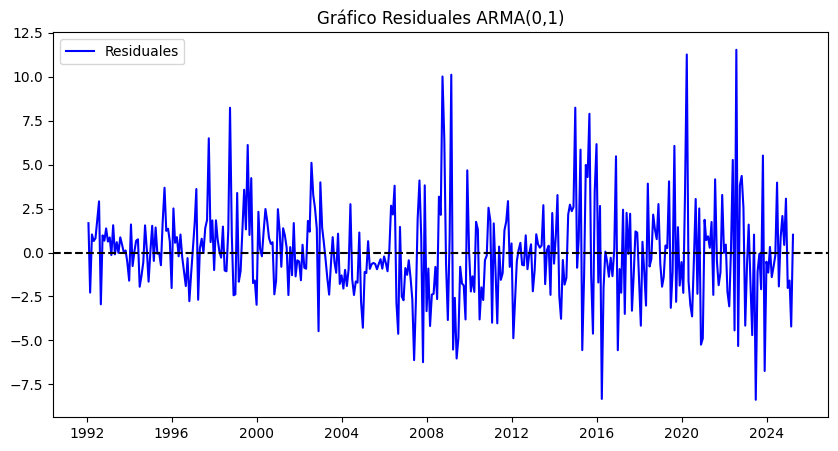

In [10]:
model = ARIMA(data_trm2['retorno'], order=(0, 0, 1))
model_fit = model.fit()

residuales = model_fit.resid

plt.figure(figsize=(10,5))
plt.plot(residuales, label="Residuales", color="blue")
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Gráfico Residuales ARMA(0,1)")
plt.legend()
plt.savefig("output\\graf_resid.png", dpi=300, bbox_inches='tight')
plt.show()

Histograma residuales:

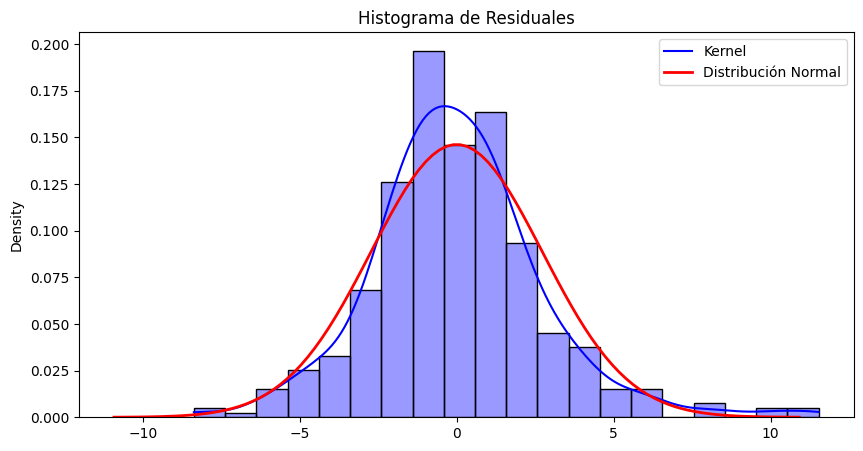

In [11]:
mu, sigma = np.mean(residuales), np.std(residuales)

x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
y = sc.stats.norm.pdf(x, mu, sigma)

plt.figure(figsize=(10,5))
sns.histplot(residuales, bins=20, kde=True, stat="density", line_kws={'label': "Kernel"}, color="blue", alpha=0.4)
plt.plot(x, y, 'r', label="Distribución Normal", linewidth=2)
plt.legend()
plt.title("Histograma de Residuales")
plt.savefig("output\\hist_resid.png", dpi=300, bbox_inches='tight')
plt.show()

Autocorrelaciones

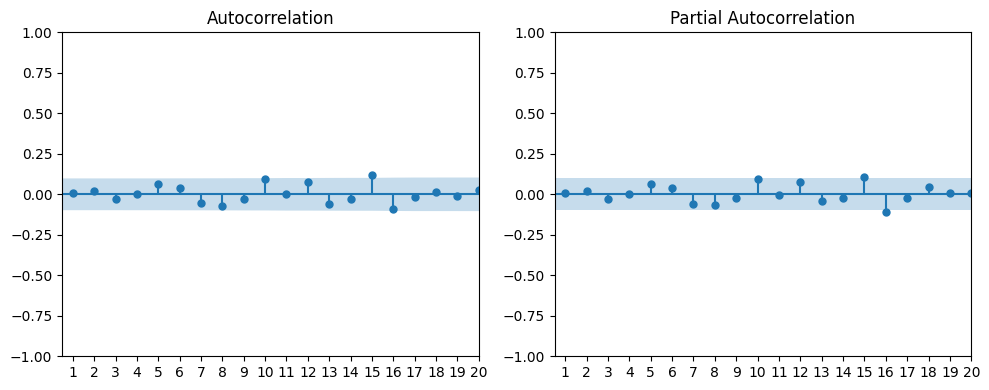

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_acf(residuales, ax = axes[0], alpha=0.05, lags=20)
plot_pacf(residuales, ax = axes[1], alpha=0.05, lags=20)

for ax in axes:
    xticks = ax.get_xticks()  
    ax.set_xticks(np.arange(1, 20 + 1)) 
    ax.set_xlim(0.5, 20)

plt.savefig("output\\acf_pacf_residuales.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

QQ plot

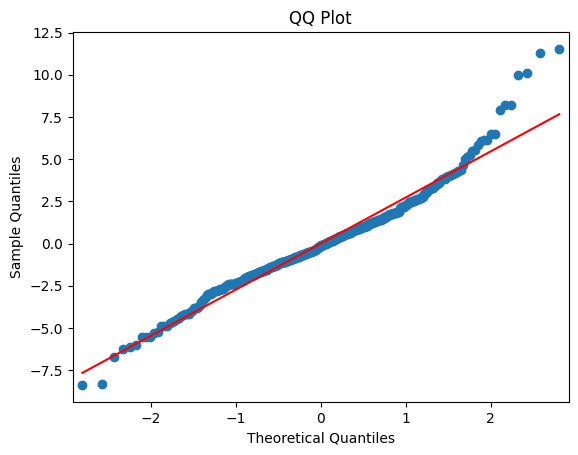

In [13]:
stats.qqplot(residuales, line='s')
plt.title("QQ Plot")
plt.savefig("output\\qq_plot_residuales.png", dpi=300, bbox_inches='tight')
plt.show()

Prueba Q

In [14]:
q_test = smd.acorr_ljungbox(residuales, lags=[5,10,15], return_df=True)

q_test = q_test.rename(columns={'lb_stat':"Estad\\'istico",'lb_pvalue':'P-Valor'})

latex_table = q_test.to_latex(index=True, label="tab:q_test_resid", na_rep='0',multicolumn=True,position='H',float_format="%.4f")
latex_table = latex_table.replace("\\begin{tabular}", "\\centering\n\\begin{tabular}")
latex_table = latex_table.replace("\\end{tabular}", f"\\end{{tabular}}\n\\caption{{Prueba Q Residuales}}")

with open("output\\prueba_q_residuales.tex", "w") as f:
     f.write(latex_table)

## **2.f. Dinámicas de varianza**

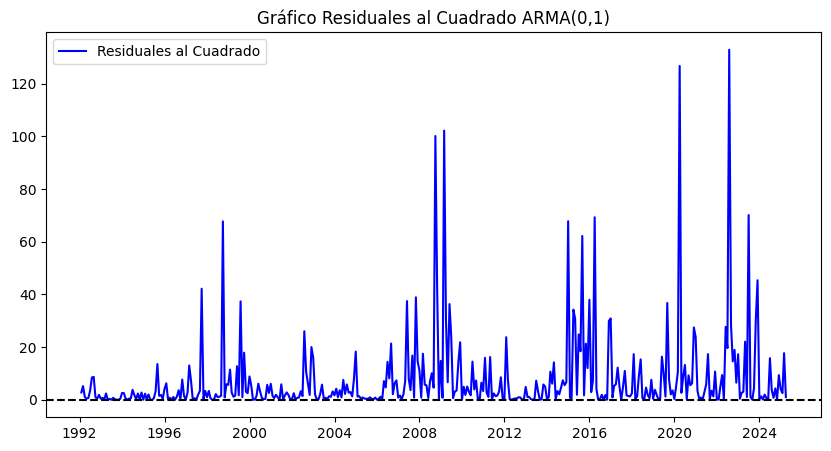

In [15]:
residuales2 =residuales ** 2

plt.figure(figsize=(10,5))
plt.plot(residuales2, label="Residuales al Cuadrado", color="blue")
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Gráfico Residuales al Cuadrado ARMA(0,1)")
plt.legend()
plt.savefig("output\\graf_resid2.png", dpi=300, bbox_inches='tight')
plt.show()

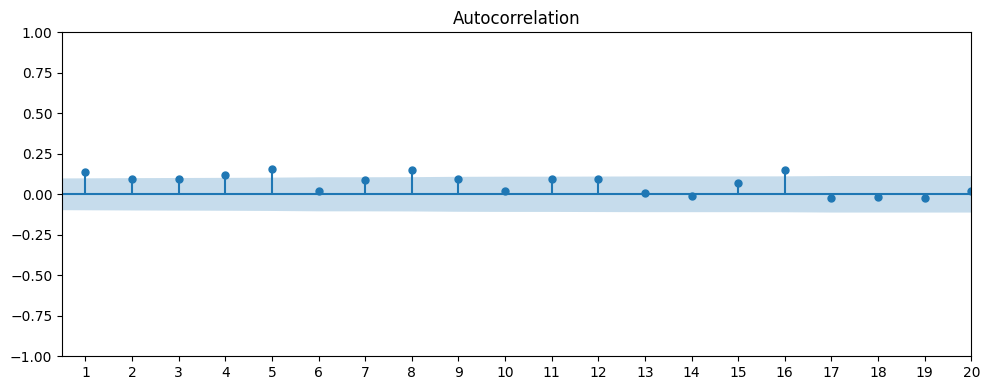

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(10, 4))

plot_acf(residuales2, ax = axes, alpha=0.05, lags=20)

xticks = axes.get_xticks()  
axes.set_xticks(np.arange(1, 20 + 1)) 
axes.set_xlim(0.5, 20)

plt.savefig("output\\acf_residuales2.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [17]:
q_test = smd.acorr_ljungbox(residuales2, lags=[5,10,15], return_df=True)

q_test = q_test.rename(columns={'lb_stat':"Estad\\'istico",'lb_pvalue':'P-Valor'})

latex_table = q_test.to_latex(index=True, label="tab:q_test_resid2", na_rep='0',multicolumn=True,position='H',float_format="%.4f")
latex_table = latex_table.replace("\\begin{tabular}", "\\centering\n\\begin{tabular}")
latex_table = latex_table.replace("\\end{tabular}", f"\\end{{tabular}}\n\\caption{{Prueba Q Residuales al Cuadrado}}")

with open("output\\prueba_q_residuales2.tex", "w") as f:
     f.write(latex_table)

Estimamos GARCH

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1304.7085947999708
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1636.288159827931
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1360.3584300431135
Iteration:      4,   Func. Count:     30,   Neg. LLF: 995.5574034422042
Iteration:      5,   Func. Count:     37,   Neg. LLF: 937.9137983163698
Iteration:      6,   Func. Count:     43,   Neg. LLF: 937.856370703201
Iteration:      7,   Func. Count:     48,   Neg. LLF: 937.8541343853084
Iteration:      8,   Func. Count:     53,   Neg. LLF: 937.853817740214
Iteration:      9,   Func. Count:     58,   Neg. LLF: 937.8538016891806
Iteration:     10,   Func. Count:     62,   Neg. LLF: 937.8538016887177
Optimization terminated successfully    (Exit mode 0)
            Current function value: 937.8538016891806
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
<bound method ARCHModelResult.summary of                      Constant 

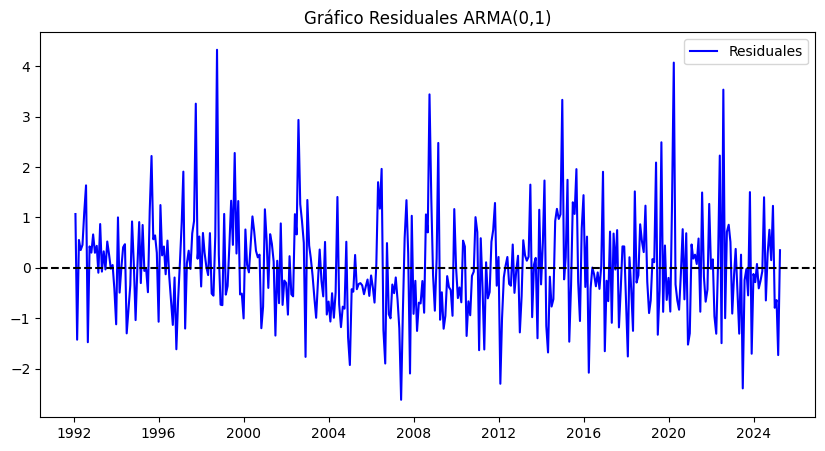

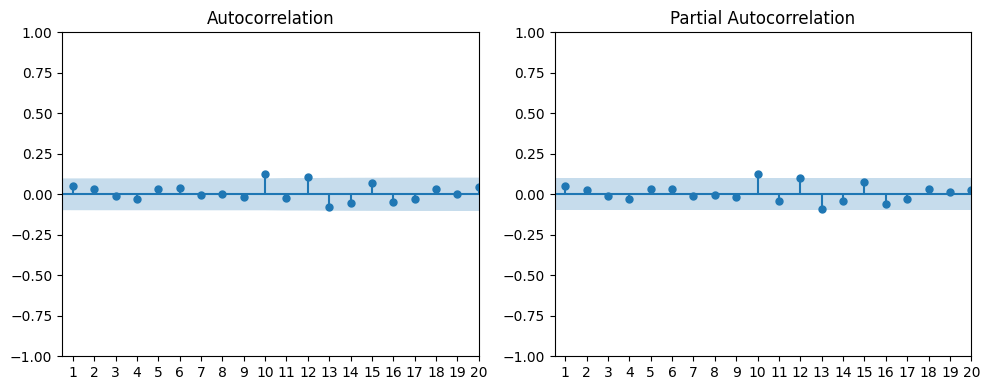

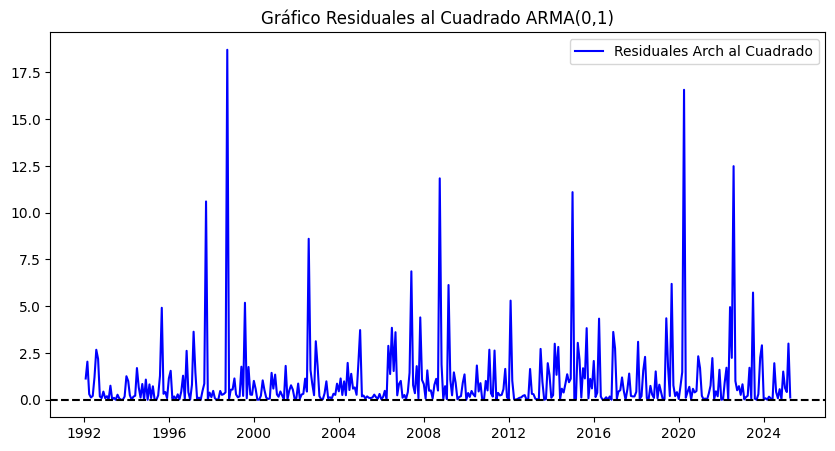

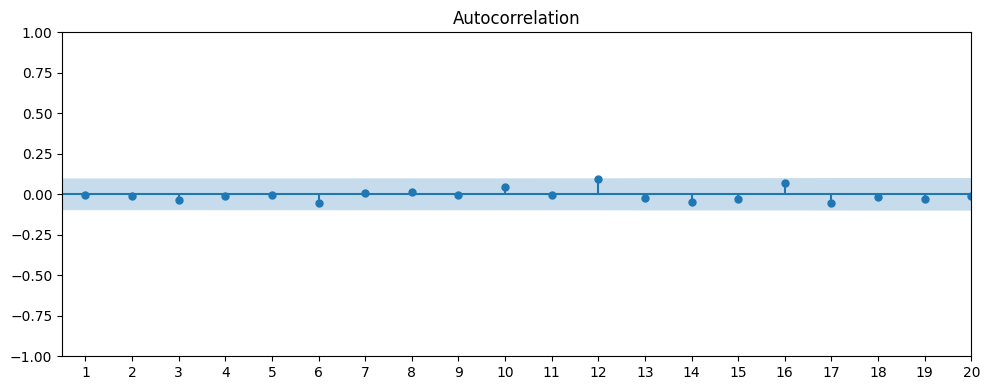

In [19]:
garch = arch_model(residuales, p=1,q=1)
g_res = garch.fit()

print(g_res.summary)

resid_arch = g_res.std_resid

resid_arch2 = resid_arch**2

# Residuales

plt.figure(figsize=(10,5))
plt.plot(resid_arch, label="Residuales", color="blue")
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Gráfico Residuales ARMA(0,1)")
plt.legend()
plt.savefig("output\\graf_resid_arch.png", dpi=300, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_acf(resid_arch, ax = axes[0], alpha=0.05, lags=20)
plot_pacf(resid_arch, ax = axes[1], alpha=0.05, lags=20)

for ax in axes:
    xticks = ax.get_xticks()  
    ax.set_xticks(np.arange(1, 20 + 1)) 
    ax.set_xlim(0.5, 20)

plt.savefig("output\\acf_pacf_residuales_arch.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

q_test = smd.acorr_ljungbox(resid_arch, lags=[5,10,15], return_df=True)

q_test = q_test.rename(columns={'lb_stat':"Estad\\'istico",'lb_pvalue':'P-Valor'})

latex_table = q_test.to_latex(index=True, label="tab:q_test_resid", na_rep='0',multicolumn=True,position='H',float_format="%.4f")
latex_table = latex_table.replace("\\begin{tabular}", "\\centering\n\\begin{tabular}")
latex_table = latex_table.replace("\\end{tabular}", f"\\end{{tabular}}\n\\caption{{Prueba Q Residuales}}")

with open("output\\prueba_q_residuales_arch.tex", "w") as f:
     f.write(latex_table)

# Rsiduales al cuadrado
plt.figure(figsize=(10,5))
plt.plot(resid_arch2, label="Residuales Arch al Cuadrado", color="blue")
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Gráfico Residuales al Cuadrado ARMA(0,1)")
plt.legend()
plt.savefig("output\\graf_resid_arch2.png", dpi=300, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(10, 4))

plot_acf(resid_arch2, ax = axes, alpha=0.05, lags=20)

xticks = axes.get_xticks()  
axes.set_xticks(np.arange(1, 20 + 1)) 
axes.set_xlim(0.5, 20)

plt.savefig("output\\acf_residuales_arch2.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

q_test = smd.acorr_ljungbox(resid_arch2, lags=[5,10,15], return_df=True)

q_test = q_test.rename(columns={'lb_stat':"Estad\\'istico",'lb_pvalue':'P-Valor'})

latex_table = q_test.to_latex(index=True, label="tab:q_test_resid2", na_rep='0',multicolumn=True,position='H',float_format="%.4f")
latex_table = latex_table.replace("\\begin{tabular}", "\\centering\n\\begin{tabular}")
latex_table = latex_table.replace("\\end{tabular}", f"\\end{{tabular}}\n\\caption{{Prueba Q Residuales al Cuadrado}}")

with open("output\\prueba_q_residuales_arch2.tex", "w") as f:
     f.write(latex_table)
